What jobs are most likely to be automated by artificial intelligence?
What are the current limitations of artificial intelligence compared to human intelligence?
In which industries is artificial intelligence already replacing human workers?
How will artificial intelligence augment human capabilities rather than replace them?
What are the potential social and economic implications of widespread artificial intelligence adoption?
Query : Will artificial intelligence replace the humans if yes than in which way
 
Results:
artificial intelligence 2 what contributes to ai? artificial intelligence is a science 
and technology based on disciplines such as computer science, biology, psychology, ling
uistics, mathematics, and engineering. a major thrust of ai is in the development of co
mputer function s associated with human intelligence, such as reasoning, learning, and 
problem solving. out of the following areas, one or multiple areas can contribute to bu
ild an intelligent system. programmi

C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\sayhe\PycharmProjects\venv_master\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' i

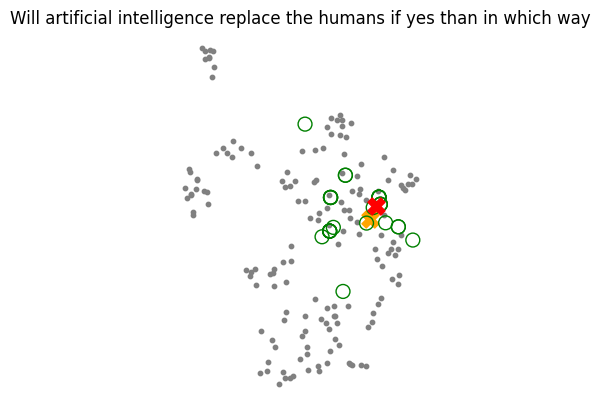

In [1]:
import pymupdf.table

from helper_utils import word_wrap, project_embeddings
from pypdf import PdfReader
import os
from groq import Groq
from dotenv import load_dotenv

load_dotenv()

groq_key=os.getenv("GROQ_API_KEY")
client = Groq(api_key=groq_key)

reader = PdfReader("artificial_intelligence.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

#filter the empty strings
pdf_texts = [text for text in pdf_texts if text]

from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,SentenceTransformersTokenTextSplitter,
)


character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n","\n",". "," ", ""],chunk_size=1000,chunk_overlap=0
)

character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))


token_splitters = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitters.split_text(text)

import umap
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
# print(embedding_function([token_split_texts[10]]))

chroma_client = chromadb.Client()
chroma_collection = chroma_client.get_or_create_collection(
    "ai-collection", embedding_function=embedding_function
)

# extract the embeddings from the token_split_texts
ids = [str(i) for i in range(len((token_split_texts)))]
chroma_collection.add(ids=ids, documents=token_split_texts)
count = chroma_collection.count()


query = "What is the meaning of Artificial Intelligence"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]

# print documents in chunks
# for document in retrieved_documents:
#     print(word_wrap(document))
#     print("\n")

def generate_multi_query(query, model="llama-3.3-70b-versatile"):
    prompt = """You are a helpful expert research assistant.You are user will ask you about provided documents,propose upto five related questions to assist them in finding the information they need.provide concise,single-topic questions(without compounding sentences) that cover various aspects of the topic.ensure each question is complete and directly related to the original inquiry. list each question on a separate line without numbering. """
    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

original_query = "Will artificial intelligence replace the humans if yes than in which way"
aug_queries = generate_multi_query(original_query)

for query in aug_queries.splitlines():
    print(query)

aug_query_list = aug_queries.splitlines()

joint_query = [original_query] + aug_query_list

#print("\n\n", joint_query)
results = chroma_collection.query(
    query_texts=joint_query,n_results=5,include=["documents", "embeddings"]
)
retrieved_documents = results["documents"]

unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i ,documents in enumerate(retrieved_documents):
    print(f"Query : {joint_query[i]}")
    print(" ")
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print("")
    print("-" * 100)

embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

# FIXED LINE:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

project_original_query_embedding = project_embeddings(
    original_query_embedding, umap_transform
)

project_augmented_query_embedding = project_embeddings(
    augmented_query_embedding, umap_transform
)

retrieved_embeddings = results["embeddings"]
result_embeddings = [item for sublist in retrieved_embeddings for item in sublist]

projected_result_embeddings = project_embeddings(result_embeddings,umap_transform)

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    projected_dataset_embeddings[:,0],
    projected_dataset_embeddings[:,1],
    s=10,
    color="gray"
)
plt.scatter(
    project_augmented_query_embedding[:, 0],
    project_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
)
plt.scatter(
    projected_result_embeddings[:, 0],
    projected_result_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    project_original_query_embedding[:, 0],
    project_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="r",
)
plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot